## Preprocessing

In [ ]:
# import the libraries
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torch.optim as optim
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import math
import copy
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.image as mpimg

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Helper function

In [ ]:
def show(dataset, labels_map={}, num_rows=0, num_cols=0, mean=[], std=[], 
         transform=False, colormap='gray', color='gray', consecutive='no',
         batch_size=0, clip='no', single='no'):

  plt.figure(figsize=(10, 10))

  if consecutive == 'yes':
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    images, _ = next(iter(loader))
    images = torchvision.utils.make_grid(images)
    images = images.numpy().transpose(1,2,0)
    if clip == 'yes':
      images = np.clip(images, 0, 1)

    if color != 'gray':
      if transform == False:
          images = images*np.array(std) + np.array(mean)

    plt.imshow(images)

  else:

    if single == 'yes':
      num_rows = num_cols = 1
    else:
      num_rows = num_rows
      num_cols = num_cols

    for i in range(num_rows*num_cols):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      image, label = dataset[sample_idx]
      if single!= 'yes':
        plt.subplot(num_rows, num_cols, i+1)

      if color == 'gray':
        image = image.squeeze()
        
        if colormap == 'gray':
          plt.imshow(image, cmap='gray')
        else:
          plt.imshow(image, cmap= colormap)

      else:

        image = image.numpy().transpose(1,2,0)
        if clip == 'yes':
          image = np.clip(image, 0, 1)

        if transform == False:
          image = image*np.array(std) + np.array(mean)

        plt.imshow(image)

      plt.axis('off')      
      plt.title(labels_map[label.item()], size=20) # if label is tensor, .item()
  plt.axis('off')

  plt.show()

In [ ]:
class make_class_names(dict):

  def __init__(self):
    self = dict()

  def add(self, key, value):
    self[key] = value

In [ ]:
def histogram(index, labels_map, dataset):
  image, label = dataset[index]
  image = image.numpy().transpose(1,2,0)
  # image = image*std.numpy() + mean.numpy()
  plt.figure(figsize=(7, 7))
  plt.subplot(1,2,2)
  plt.title(labels_map[label.item()], size=20)
  plt.imshow(image)
  plt.axis('off')
  histo = plt.subplot(1,2,1)
  histo.set_xlabel('Pixel Intensity')
  histo.set_ylabel('Count')
  colormap = ['g', 'r', 'blue', 'y', 'black']
  x = np.random.randint(len(colormap))
  plt.hist(image.flatten(), bins=10, color=colormap[x], alpha=0.5)
  plt.show()

def histograms(num, labels_map, dataset):
  for i in range(num):
    index = np.random.randint(len(dataset))
    histogram(index, labels_map, dataset)

In [ ]:
def cal_normalize(dataset):
  num_channels = 3
  psum = torch.zeros(num_channels)
  psum_sq = torch.zeros(num_channels)

  for image, _ in dataset: # unpack images only
    psum += image.sum(axis=[1, 2]) # torch.Size([3, 100, 100]) C x M x N w.r.t C
    psum_sq += (image**2).sum(axis=[1, 2])

  total_pxl = len(dataset) * 100 * 100

  mean = psum / total_pxl
  var = (psum_sq / total_pxl) - (mean**2)
  std = torch.sqrt(var)

  return mean, std

In [ ]:
def visualize_cost (loss_train, acc_train, loss_val, acc_val):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,7))
    plt.grid()
    plt.subplot(1,2,1)

    plt.plot(np.array(loss_train), '-o', label='train', linewidth=2)
    plt.plot(np.array(loss_val), '-o', label='val', linewidth=2)
    plt.xlabel('$Epochs$', size=20)
    plt.ylabel('$Loss$', size=20)
    plt.legend(loc='best', fontsize=20)
    
    plot2 = plt.subplot(1,2,2)
    plot2.plot(np.array(acc_train), '-o', label='train', linewidth=2)
    plot2.plot(np.array(acc_val), '-o', label='val', linewidth=2)
    plot2.set_xlabel('$Epochs$', size=20)
    plot2.set_ylabel('$Acc$', size=20)
    plot2.legend(loc='best', fontsize=20)
    plot2.grid(True)

    plt.show()

In [ ]:
def visualize_model(labels_map, num_rows, num_cols, dataset, mean, std, predicted_class):

  plt.figure(figsize=(10, 10))

  for i in range(num_rows*num_cols):
    plt.subplot(num_rows, num_cols, i+1)
    index = torch.randint(len(dataset), size=(1,)).item()
    image, label = dataset[index]
    image = image.cpu().numpy().transpose(1,2,0)
    image = image * np.array(std) + np.array(mean)
    # image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label.item() == predicted_class[index]:
      check = 'green'
    else: check = 'red'
    plt.title(f'Pred: {labels_map[predicted_class[index]]}', color='white',
              backgroundcolor=check, fontsize=15)

  plt.show()

In [ ]:
def get_predictions(loader, model):

  model.eval()

  predicted_class = np.array([])
  targets = np.array([])

  with torch.no_grad():
    for idx, (images, labels) in enumerate(loader):

      labelsnp = labels.cpu().numpy()
      targets = np.concatenate((targets, labelsnp), axis=None)

      images = images.to(device) # torch.Size([3, 3, 224, 224]) train_dataset
      labels = labels.to(device) # torch.Size([3])

      y_predicted = model(images) # torch.Size([3, 5])
      _, index = torch.max(y_predicted, 1)

      convert = index.cpu().numpy()
      predicted_class = np.concatenate((predicted_class, convert), axis=None)

  return targets, predicted_class

In [ ]:
def check_accuracy(loader, loader_dataset, model, labels_map):

  if loader == val_loader:
    print('Val Acc')
  elif loader == train_loader:
    print('Train Acc')
  else:
    print('Test Acc')

  running_corrects = 0
  num_samples = 0
  absent_class = []

  num_classes = len(list(labels_map.values()))

  n_correct_class = [0 for i in range(num_classes)]
  n_class_samples = [0 for i in range(num_classes)]

  model.eval()

  with torch.no_grad():

    for images, labels in loader:

      images = images.to(device)
      labels = labels.to(device)

      y_predicted = model(images)
      _, index = torch.max(y_predicted, 1)

      running_corrects += (index == labels.data).sum()

      temp_ = index.cpu().numpy()
      num_samples += temp_.shape[0]

      temp = labels.cpu().numpy()

      for i in range(temp.shape[0]):
        
        label = temp[i]
        index_i = temp_[i]

        if label == index_i:
          n_correct_class[label] += 1
        n_class_samples[label] += 1

    convert = running_corrects.double()
    acc = convert / len(loader_dataset)
    print(f'Got {int(convert.item())}/{num_samples} correct samples over {acc.item() * 100:.2f}%')

    for i in range(num_classes):
      if n_class_samples[i] != 0:
        acc_ = 100 * n_correct_class[i] / n_class_samples[i]
        print(f'Accuracy of {labels_map[i]}: {acc_:.2f}%')
      else:
        absent_class.append(i)
        print(f'Class {labels_map[i]} does not have its sample in this dataset.')

  return absent_class

In [ ]:
def report_accuracy(targets, preds, labels_map, absent_class, num_classes):
  
  print(classification_report(targets, preds))
  cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
  index = np.random.randint(0, len(cmap_list))

  labels = list(labels_map.values())

  cm = confusion_matrix(targets, preds)
  temp = np.zeros(num_classes-1)
  for item in absent_class:
    cm = np.insert(cm, item, temp, axis=0)
  temp = np.zeros(num_classes)
  for item in absent_class:
    cm = np.insert(cm, item, temp, axis=1)

  df_cm = pd.DataFrame(cm, labels, labels)
  sn.heatmap(df_cm, annot_kws={"size": 16}, annot=True, cmap=cmap_list[index], fmt = 'g')
  sn.set(font_scale=1.4)
  plt.title('Confusion Matrix')
  plt.ylabel('Correct-label', fontsize=20)
  plt.xlabel('Predicted-label', fontsize=20)
  plt.show()

In [ ]:
def report(model, loader, loader_dataset, labels_map, targets, preds, num_classes):
  print("")
  absent = check_accuracy(loader, loader_dataset, model, labels_map)
  print("")
  report_accuracy(targets, preds, labels_map, absent, num_classes)

In [ ]:
def predict(model, image_path, transform, labels_map, mean, std):

  image = Image.open(image_path).convert('RGB')
  image = transform(image)
  image = image.unsqueeze(0)
  image = image.to('cuda')

  model.eval()
  with torch.no_grad():

    y_predicted = model(image)
    _, index = torch.max(y_predicted, 1)

  pred = index.cpu().numpy()
  predicted_class = int(pred[0])

  img = mpimg.imread(image_path)
  plt.imshow(img)

  plt.title(f'Predicted: {labels_map[predicted_class]}', size=20)
  plt.axis('off')
  plt.show()

def predict_single(model, image_path):
  predict(model, image_path, visualize_trans, boys, mean, std)

In [ ]:
class BoysDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__ (self, index):

        image = self.annotations.iloc[index, 0] # first column of the csv file
                                                     # format i.e: class_name1_01.jpg
                                                     #             class_name1_02.jpg
        temp = image.split('.')
        folder_name = temp[0]
        folder_name = folder_name[:-3]                # extract the class_name from image_name
        root_directory = os.path.join(self.root_dir, folder_name)

        image_path = os.path.join(root_directory, self.annotations.iloc[index, 0])
        image = Image.open(image_path).convert('RGB') # IMPORTANT! A usual image has an extra 'alpha' channel.
                                                      # image imported using PIL alr a PIL image, otherwise
                                                      # you have to set them in transforms!
        y_label = torch.tensor(self.annotations.iloc[index, 1])

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [ ]:
def save_checkpoint(state, is_best, filename='check_point.pth'):
  root_dir = '/content/drive/MyDrive/saved_ckpnt'
  if is_best:
    print('==> Saving new best')
    torch.save(state, os.path.join(root_dir, filename))
  else:
    print('==> Validation accuracy did not improve.')

## Dataset preparation

In [ ]:
# # conduct csv file
# dir = '/content/drive/MyDrive/boys_dataset/train'
# dir = '/content/drive/MyDrive/boys_dataset/val'
# i=0
# headerlist = ['image_name', 'target'] # make sure to have header row
# with open('/content/drive/MyDrive/boys_train.csv', 'w') as f:
#   f.write(headerlist[0] + ',' + headerlist[1] + '\n') # otherwise, your dataset would be missed one sample!
#   for folder in os.listdir(dir):
#     folder_path = os.path.join(dir, folder)
#     for image in os.listdir(folder_path):
#       f.write(image + ',' + str(i) + '\n')
#     i+=1
# print('Done.')

Done.


In [ ]:
train_csv_file = '/content/drive/MyDrive/boys_train.csv'
val_csv_file = '/content/drive/MyDrive/boys_val.csv'

train_dir = '/content/drive/MyDrive/boys_dataset/train'
val_dir = '/content/drive/MyDrive/boys_dataset/val'

In [ ]:
boys = make_class_names()
i=0
for folder in os.listdir(train_dir):
  boys.add(i, folder)
  i+=1
print(boys)

{0: 'timmy_xu', 1: 'corbyn_besson', 2: 'keita_machida', 3: 'wang_kai', 4: 'chau_minh_chi'}


In [ ]:
boys = make_class_names()
i=0
for folder in os.listdir(val_dir):
  boys.add(i, folder)
  i+=1
print(boys)

{0: 'timmy_xu', 1: 'corbyn_besson', 2: 'keita_machida', 3: 'wang_kai', 4: 'chau_minh_chi'}


In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:
trans1 = transforms.Compose([
                             transforms.Resize((224, 224)),
                             transforms.RandomHorizontalFlip(p=0.5),
                             transforms.RandomAdjustSharpness(sharpness_factor=2),
                             transforms.ToTensor(),
                             transforms.Normalize(mean, std)
])

trans2 = transforms.Compose([
                             transforms.Resize((224, 224)),
                             transforms.RandomPosterize(bits=2),
                             transforms.RandomAutocontrast(),
                             transforms.ToTensor(),
                             transforms.Normalize(mean, std)
])

visualize_trans = transforms.Compose([
                                   transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean, std)
])

In [ ]:
dataset = BoysDataset(csv_file = train_csv_file, root_dir=train_dir, transform = visualize_trans)
print(len(dataset))

100


In [ ]:
train_dataset = BoysDataset(csv_file = train_csv_file, root_dir = train_dir, transform = trans1)
val_dataset = BoysDataset(csv_file = val_csv_file, root_dir = val_dir, transform = trans2)

In [ ]:
print(len(train_dataset))
print(len(val_dataset))

100
75


In [ ]:
# actually I don't have to structure your dataset like hymeopetra format!
# such complexity!
val_size = int(len(val_dataset) * 0.8)
test_size = len(val_dataset) - val_size
val_dataset, test_dataset = torch.utils.data.random_split(dataset=val_dataset, lengths=[val_size, test_size])
print(len(val_dataset), len(test_dataset))

60 15


## Normalization

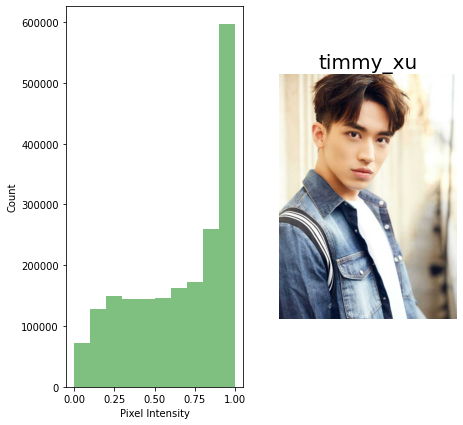

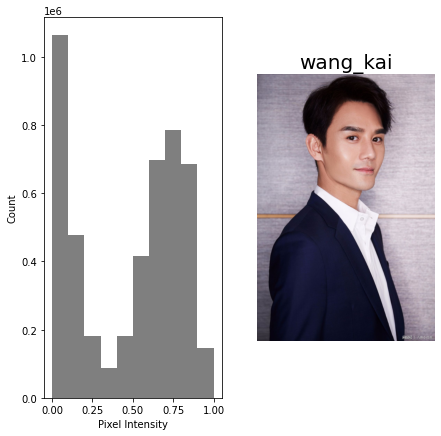

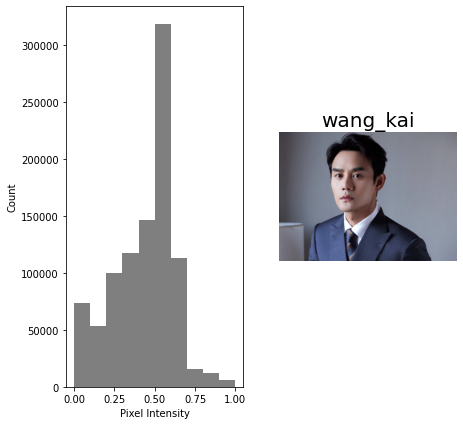

In [ ]:
histograms(3, boys, dataset) # raw images without resize
## ==> the image pixels are alr in range (0, 1)

In [ ]:
# calculate mean, std w.r.t this dataset
# images should be resized before calculate
mean, std = cal_normalize(dataset)
print(mean, std)
# ==> tensor([2.4166, 2.3268, 2.3325]) tensor([nan, nan, nan])
# since std values are unspecified, we are not going to use this mean and std

tensor([2.4166, 2.3268, 2.3325]) tensor([nan, nan, nan])


## Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


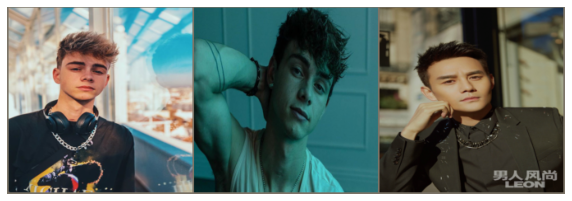

In [ ]:
show(dataset, mean=mean, std=std, transform=False, consecutive='yes', color='yes', batch_size=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


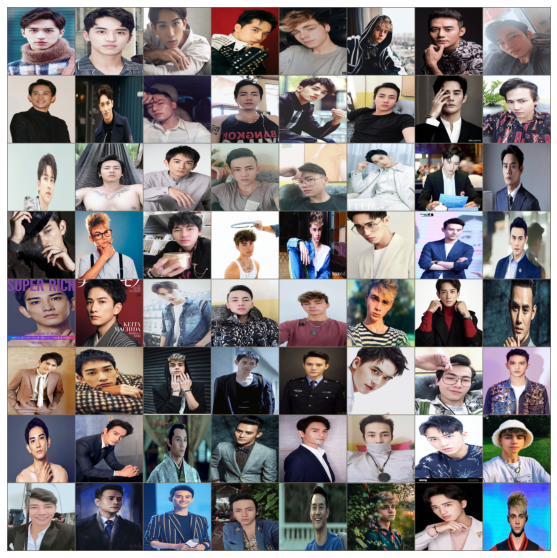

In [ ]:
show(dataset, mean=mean, std=std, transform=False, consecutive='yes', color='yes', batch_size=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


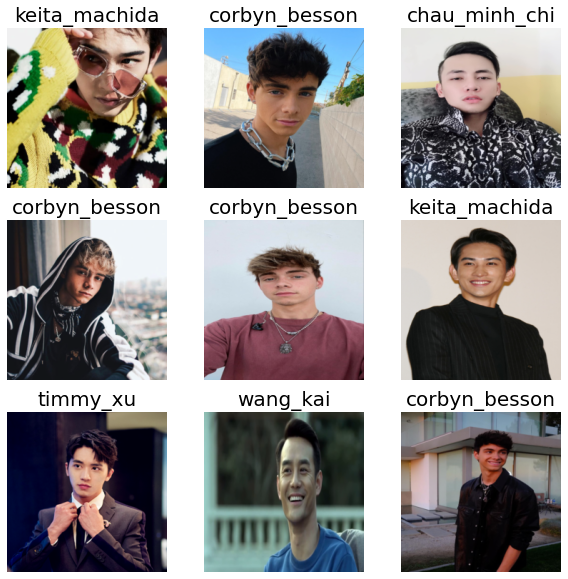

In [ ]:
show(dataset, boys, 3, 3, mean=mean, std=std, transform=False, color='yes')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


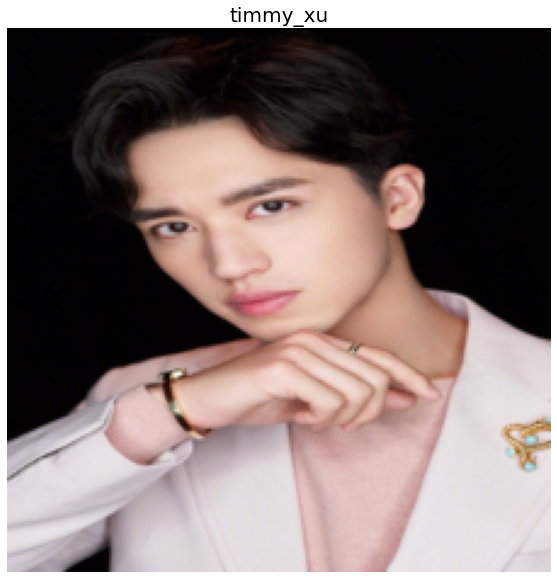

In [ ]:
show(dataset, boys, mean=mean, std=std, transform=False, color='yes', single='yes')

In [ ]:
dir = '/content/drive/MyDrive/boys_dataset/train'
count_classes = make_class_names()
for folder in os.listdir(dir):
  count=0
  folder_path = os.path.join(dir, folder)
  for image in os.listdir(folder_path):
    count+=1
  count_classes.add(folder, [count])
print(count_classes)

{'timmy_xu': [20], 'corbyn_besson': [20], 'keita_machida': [20], 'wang_kai': [20], 'chau_minh_chi': [20]}


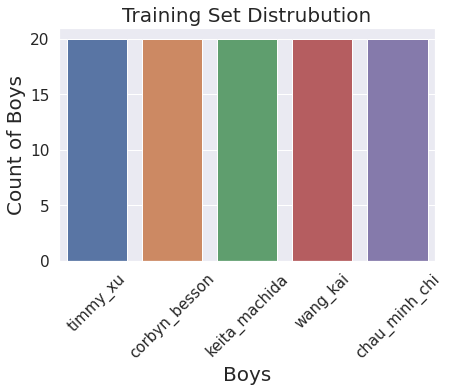

In [ ]:
df = pd.DataFrame.from_dict(count_classes)
sn.barplot(data=df)

index = np.arange(df.shape[1])
classes = list(boys.values())

plt.xlabel('Boys', fontsize=20)
plt.ylabel('Count of Boys', fontsize=20)
plt.xticks(index, classes, fontsize=15, rotation=45)
plt.title('Training Set Distrubution', fontsize=20)
plt.show()

## Training Preparation

In [ ]:
# Hyperparameter
num_epochs = 25
begin_epoch = 0
batch_size = 3
learning_rate = 0.001
load_model = False
load_model_file = '/content/drive/MyDrive/saved_ckpnt/checkpoint.pth'
num_classes = 5

In [ ]:
if load_model:
  loaded = torch.load(load_model_file)
  begin_epoch = loaded['epoch']
  best_acc = loaded['best_val_acc']
  print(f'Training resumes at epoch {begin_epoch}')
  print(f'Last best validation accuracy is {best_acc}')

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# writer = SummaryWriter(f'/content/drive/MyDrive/training_boys_dataset/visualize')

In [ ]:
# images, _ = next(iter(train_loader))
# out = torchvision.utils.make_grid(images)
# writer.add_image('boys_dataset', out)
# writer.close()

In [ ]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir '/content/drive/MyDrive/training_boys_dataset/visualize'

## Load model

In [ ]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
  param.requires_grad = False

In [ ]:
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 5)

In [ ]:
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
if load_model:
  loaded = torch.load(load_model_file)
  model.load_state_dict(loaded['model'])
  optimizer.load_state_dict(loaded['optimizer'])

In [ ]:
model = model.to(device)

## Training

In [ ]:
writer_train = SummaryWriter(f'/content/drive/MyDrive/training_boys/train')
writer_val = SummaryWriter(f'/content/drive/MyDrive/training_boys/val')

In [ ]:
n_iters1 = math.ceil(len(train_dataset) / batch_size)
n_iters2 = math.ceil(len(val_dataset) / batch_size)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
start = time.time()

step = 0
step2 = 0

if load_model:
  loaded = torch.load(load_model_file)
  loss_cache_train = loaded['loss']
  acc_cache_train = loaded['acc']
  loss_cache_val = loaded['loss_val']
  acc_cache_val = loaded['acc_val']
  best_acc = loaded['best_val_acc']
else:
  loss_cache_train = []
  acc_cache_train = []
  loss_cache_val = []
  acc_cache_val = []

for epoch in range(begin_epoch, num_epochs):

  model.train()
  start_epoch = time.time()

  running_corrects = 0
  running_loss = 0.0

  for idx1, (images, labels) in enumerate(train_loader):

    images = images.to(device)
    labels = labels.to(device)

    y_predicted = model(images)
    loss = criterion(y_predicted, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, index = torch.max(y_predicted, 1)
    running_corrects += torch.sum(index == labels)
    running_loss += loss.item() * images.size(0)

  epoch_loss = running_loss / len(train_dataset)
  epoch_acc = running_corrects / len(train_dataset)

  loss_cache_train.append(epoch_loss)
  acc_cache_train.append(epoch_acc.item())

  writer_train.add_scalar('Epoch_loss', epoch_loss, global_step=step)
  writer_train.add_scalar('Epoch_accuracy', epoch_acc, global_step=step)
  step+=1
  
  model.eval()

  running_corrects = 0
  running_loss = 0.0

  for idx2, (images, labels) in enumerate(val_loader):
    
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      
      y_predicted = model(images)
      loss = criterion(y_predicted, labels)

      _, index = torch.max(y_predicted, 1)
      running_corrects += torch.sum(index == labels)
      running_loss += loss.item() * images.size(0)

  epoch_loss_val = running_loss / len(val_dataset)
  epoch_acc_val = running_corrects / len(val_dataset)

  loss_cache_val.append(epoch_loss_val)
  acc_cache_val.append(epoch_acc_val.item())

  writer_val.add_scalar('Epoch_loss', epoch_loss_val, global_step=step2)
  writer_val.add_scalar('Epoch_accuracy', epoch_acc_val, global_step=step2)
  step2+=1

  is_best = bool(epoch_acc_val > best_acc)
  if is_best:
    best_acc = epoch_acc_val
    best_model_wts = copy.deepcopy(model.state_dict())
    num_epoch_trained = begin_epoch + epoch + 1
    checkpoint = {
            'epoch': num_epoch_trained,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': loss_cache_train,
            'acc': acc_cache_train,
            'loss_val': loss_cache_val,
            'acc_val': acc_cache_val,
            'best_val_acc': best_acc.item()
    }
    temp = best_acc.item()
    name = 'ckpt_epch' + str(num_epoch_trained) + '_acc' + str(round(temp, 5)) + '.pth'
    save_checkpoint(checkpoint, is_best, name)
  else: 
    checkpoint = {}
    save_checkpoint(checkpoint, is_best, 'nothing')

  end_epoch = time.time()

  print(f'Epoch {epoch+1}/{num_epochs}')
  print(f'Step {idx1+1}/{n_iters1}, train Loss = {epoch_loss:.2f},  train Acc = {epoch_acc:.2f}')
  print(f'Step {idx2+1}/{n_iters2}, val loss = {epoch_loss_val:.2f},  val acc = {epoch_acc_val:.2f}')

  epoch_elapse = end_epoch - start_epoch
  print(f'Time spent for this epoch -----> {int(epoch_elapse // 60)}m {int(epoch_elapse % 60)}s')
  print("")

end = time.time()
duration = end - start
print(f'Training completes in {int(duration // 60)}m {int(duration % 60)}s')
print(f'Best val Acc: {best_acc:.4f}')
model.load_state_dict(best_model_wts)

==> Saving new best
==> Saving new best
Epoch 1/25
Step 34/34, train Loss = 1.84,  train Acc = 0.29
Step 20/20, val loss = 1.58,  val acc = 0.25
Time spent for this epoch -----> 0m 32s

==> Saving new best
==> Saving new best
Epoch 2/25
Step 34/34, train Loss = 0.91,  train Acc = 0.63
Step 20/20, val loss = 1.53,  val acc = 0.43
Time spent for this epoch -----> 0m 13s

==> Validation accuracy did not improve.
Epoch 3/25
Step 34/34, train Loss = 0.61,  train Acc = 0.82
Step 20/20, val loss = 1.67,  val acc = 0.27
Time spent for this epoch -----> 0m 8s

==> Validation accuracy did not improve.
Epoch 4/25
Step 34/34, train Loss = 0.47,  train Acc = 0.87
Step 20/20, val loss = 1.66,  val acc = 0.32
Time spent for this epoch -----> 0m 8s

==> Validation accuracy did not improve.
Epoch 5/25
Step 34/34, train Loss = 0.42,  train Acc = 0.86
Step 20/20, val loss = 1.49,  val acc = 0.37
Time spent for this epoch -----> 0m 8s

==> Validation accuracy did not improve.
Epoch 6/25
Step 34/34, train 

<All keys matched successfully>

## Evaluation

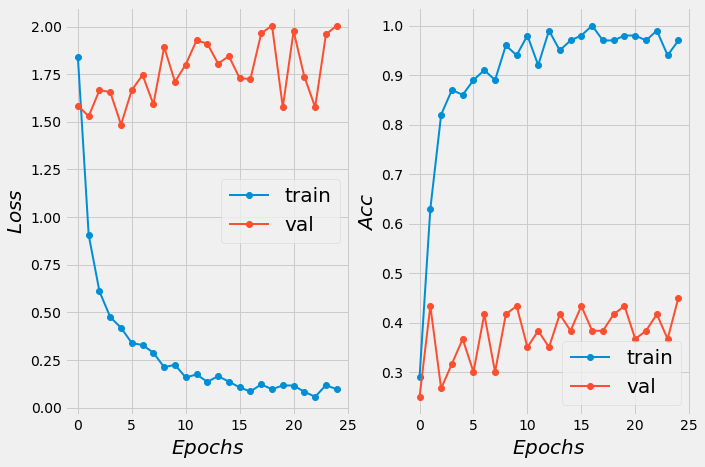

In [ ]:
visualize_cost(loss_cache_train, acc_cache_train, loss_cache_val, acc_cache_val)

In [ ]:
!tensorboard dev upload \
--logdir  '/content/drive/MyDrive/training_boys' \
--name 'boys_train' \
--description 'training on boys dataset 25 epochs vgg16' \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/drive/MyDrive/training_boys

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=wTqxYrDp4cHPqkNgBuenfx3qErj8dm&prompt=cons

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/KNuQ1DVYRXCKmTrKiBRHQg/
	Name                 boys_train
	Description          training on boys dataset 25 epochs vgg16
	Id                   KNuQ1DVYRXCKmTrKiBRHQg
	Created              2022-06-10 05:04:31 (1 minute ago)
	Updated              2022-06-10 05:04:31 (1 minute ago)
	Runs                 2
	Tags                 2
	Scalars              100
	Tensor bytes         0
	Binary object bytes  0
https://tensorboard.dev/experiment/Uv4jhLBmSZC1xOaWqQt2Kg/
	Name                 boys_parameter_search
	Description          exhaustive search for learning rate and batch_size matching
	Id                   Uv4jhLBmSZC1xOaWqQt2Kg
	Created              2022-06-10 03:04:13 (2 hours ago)
	Updated              2022-06-10 03:04:14 (2 hours ago)
	Runs                 27
	Tags                 5
	Scalars              54
	Tensor bytes         6966
	Binary object bytes  0
Total: 2 experiment(s)


In [ ]:
targets, preds = get_predictions(test_loader, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


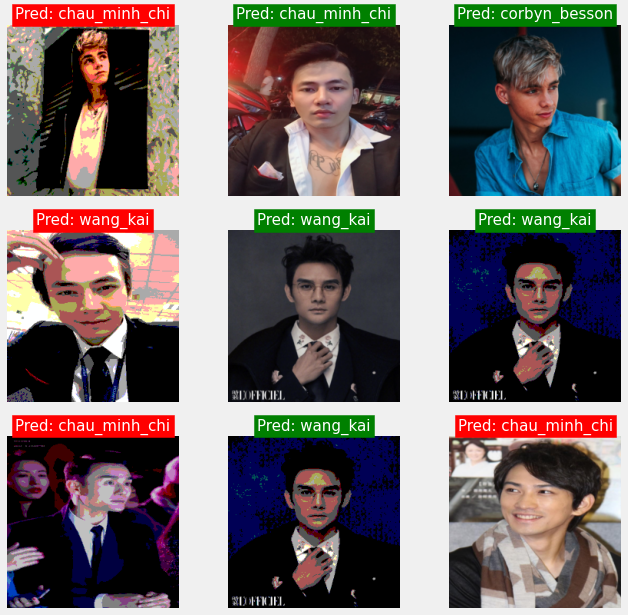

In [ ]:
visualize_model(boys, 3, 3, test_dataset, mean, std, preds)


Test Acc
Got 7/15 correct samples over 46.67%
Class timmy_xu does not have its sample in this dataset.
Accuracy of corbyn_besson: 33.33%
Accuracy of keita_machida: 0.00%
Accuracy of wang_kai: 50.00%
Accuracy of chau_minh_chi: 100.00%

              precision    recall  f1-score   support

         1.0       1.00      0.33      0.50         3
         2.0       0.00      0.00      0.00         4
         3.0       0.40      0.50      0.44         4
         4.0       0.38      0.75      0.50         4

    accuracy                           0.40        15
   macro avg       0.44      0.40      0.36        15
weighted avg       0.41      0.40      0.35        15



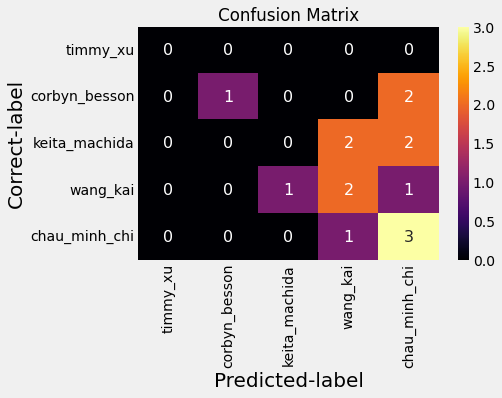

In [ ]:
report(model, test_loader, test_dataset, boys, targets, preds, num_classes)

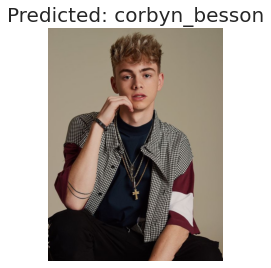

In [ ]:
image_path = '/content/drive/MyDrive/predict_img/A-6282146-1557120352-2816.jpg'
predict_single(model, image_path)